In [498]:
from random import *
import numpy as np
import matplotlib.pyplot as plt
from math import *

##### On commence par donner un aperçu de la position réelle ainsi que la vitesse réelle du véhicule 

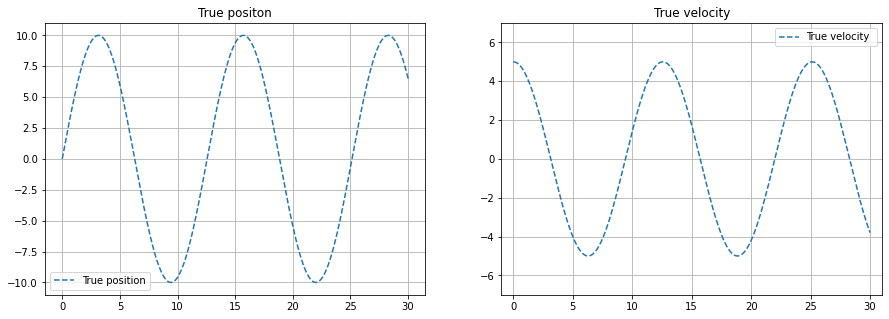

In [557]:
### For  sinusoidal input
v0,x0 = 5,0
t = np.linspace(0,30,3000)
x = 10*np.sin(0.5*t) # True position
V=  5*np.cos(0.5*t) # True velocity


######################
plt.figure(2,figsize=(15,5))
plt.subplot(121)
plt.plot(t, x, '--', label='True position')
plt.grid()
plt.legend()
plt.title("True positon")
plt.subplot(122)
plt.plot(t,V,'--',label = "True velocity ")
plt.legend()
plt.title("True velocity")
plt.axis([-1,31,-7,7])
plt.grid()
plt.show()
####################

#### On simule l'allure du bruit correspondant au gps

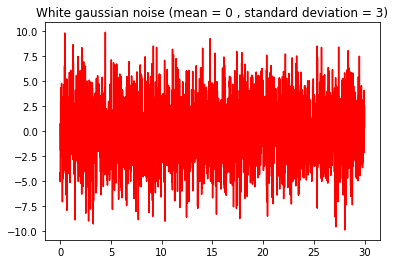

In [470]:
# White gaussian noise (mean = 0 , standard deviation = 3)
mean = 0
std = 3
num_samples = 3000
samples = np.random.normal(mean, std, size=num_samples)
plt.plot(t,samples,color = "red")
plt.title("White gaussian noise (mean = 0 , standard deviation = 3)")
plt.show()

#### On simule l'allure du bruit correspondant au gps

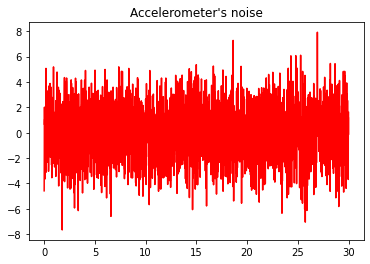

In [471]:
acc_noise =np.random.normal(mean, 2, size=num_samples)
plt.plot(t,acc_noise,color= "red") 
plt.title("Accelerometer's noise")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


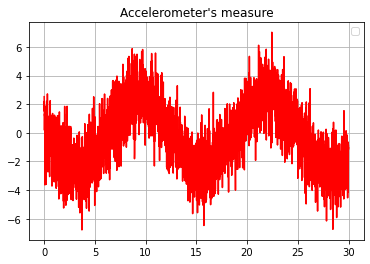

In [500]:
X_acc = acc_noise -0.25*x
plt.plot(t,X_acc,color= "red") 
plt.title("Accelerometer's measure")
plt.legend()
plt.grid()
plt.show()

#### On simule les mesures données par le gps

Text(0.5, 1.0, 'GPS measure')

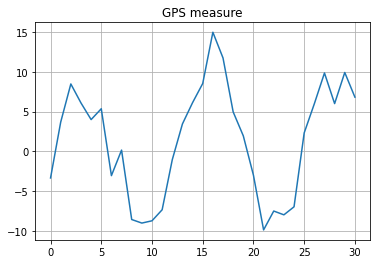

In [562]:
freq_list = [i for i in range(0,3000,100)]
freq_list.append(2999)
X_gps = [x[i] + 0.8*samples[i] for i in freq_list ]
plt.plot(X_gps)
plt.grid()
plt.title("GPS measure")

#### On implémente le filre de kalman

In [564]:
#implementation of kalman filter
P0_1 = np.array([[999999,0],[0,999999]])     # initial error state covariance matrix
x0_1 = np.array([[x0] ,[v0]])                  # Enter loop with initial state estimate

Hk =np.array([[1,0]])
Hk_T = np.transpose(Hk)

Rk = np.array([[3**2]])

Phi_K = np.array([[1,0.01],[0,1]])
Phi_K_T= np.transpose(Phi_K)

Ts = 0.01
Gamma = 2
Qk = (Gamma) * np.array([[(Ts**3)/3,(Ts**2)/2],[(Ts**2)/2,Ts]])
G_K = Ts * np.array([[0] ,[1]])


counter = 0
k=0
output = []
outputV = []
for i in range(0,3000):
    PH = np.dot(P0_1,Hk_T) # P0_1*Hk_t
    K0 = np.dot(np.dot(P0_1,Hk_T),np.linalg.inv( np.dot(Hk,PH) + 15*Rk )) #kalman gain matrix
    P0_0 = np.dot(np.eye(2)-np.dot(K0,Hk),P0_1)  # updating state vector error covariance matrix
    P1_0 =  np.dot(Phi_K , np.dot(P0_0,Phi_K_T) ) + 1*Qk # Project ahead (extrapolation/ prediction step)
    P0_1 = P1_0
    if(counter in freq_list):
        x0_0  = x0_1 + np.dot(K0, X_gps[k] - np.dot(Hk,x0_1) ) #updating the last extrapolated state vector estimate
        x1_0 = np.dot(Phi_K,x0_0) + np.dot(G_K,X_acc[i]) # Project ahead (extrapolation/ prediction step)   Acc
        output.append(x1_0[0])
        outputV.append(x1_0[1])
        k+=1
        x0_1 = x1_0
        counter+=1
    else:    
        x0_0 =  x0_1
        x1_0 = np.dot(Phi_K,x0_0) + np.dot(G_K,X_acc[i]) # Project ahead (extrapolation/ prediction step)   Acc
        output.append(x1_0[0])
        outputV.append(x1_0[1])
        x0_1 = x1_0 
        counter+=1

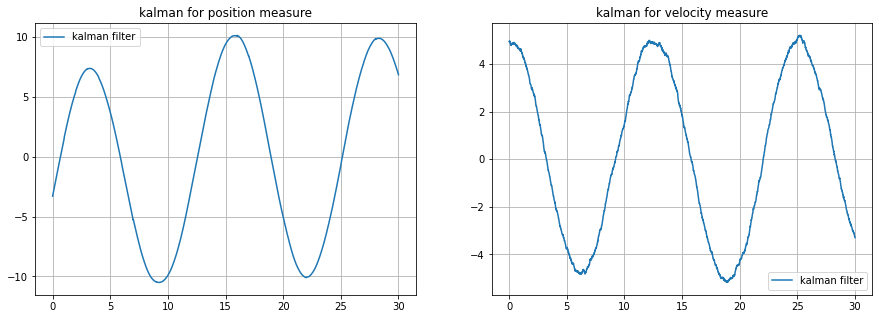

In [566]:
######################
plt.figure(2,figsize=(15,5))
plt.subplot(121)
plt.plot(t,output,label ="kalman filter")
plt.grid()
plt.legend()
plt.title("kalman for position measure")
plt.subplot(122)
plt.plot(t,outputV,label = "kalman filter" ,)
plt.legend()
plt.title("kalman for velocity measure")
plt.grid()
plt.show()
####################

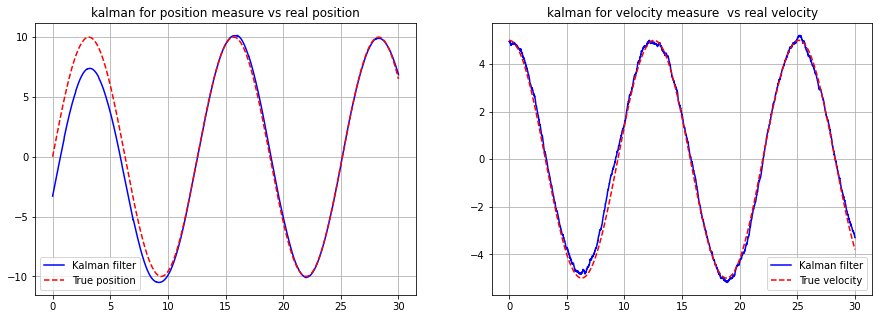

In [568]:
######################
plt.figure(2,figsize=(15,5))
plt.subplot(121)
plt.plot(t,output, label ="Kalman filter", color ="blue") 
plt.plot(t,x, '--',label ="True position", color ="red") 
plt.grid()
plt.legend()
plt.title("kalman for position measure vs real position")
plt.subplot(122)
plt.plot(t,outputV,label = "Kalman filter", color ="blue" )
plt.plot(t,V, '--',label ="True velocity", color ="red") 
plt.legend()
plt.title("kalman for velocity measure  vs real velocity")
plt.grid()
plt.show()
####################

### La figure ci dessus montre l'allure du modèle réel (en rouge) ainsi que le filtre de Kalman (en bleu).On remarque bien que le comportement du filtre de kalman se rapporche de du modèle réel

### Ici on peut voir la force du filtre qui est sa capacité de prédiction des paramètres et de rectification des erreurs, non seulement des capteurs, mais aussi du modèle lui-même.  Ce filtre fonctionne comme suit :
-  Une première étape de prédiction de l'estimation selon le modèle du système. Pour ce faire, le filtre de Kalman reprend l'estimation précédente des paramètres et de l'erreur et prédit les nouveaux paramètres et la nouvelle erreur en fonction de la modélisation du système.
Nous nous plaçons à l'instant discret k. À cet instant, nous disposons d'une estimation initiale fondée sur la connaissance du processus et des observations jusqu'à l'instant précèdent, c'est-à-dire k—1. Nous chercherons un estimateur Xk|k-i de Xk sans tenir compte de la mesure Yk, mais en utilisant uniquement l'équation :  
      Xk+1|k = Phi_k*Xk|k + G_k*U_k
    
    
-  La seconde étape va faire la mise à jour de cette prédiction grâce aux nouvelles mesures. Ces mesures (qui sont bruités) vont permettre d'obtenir une estimation des paramètres et de l'erreur à partir de la prédiction faite. Meme quand le modèle comporte des erreurs, cette étape de mise à jour permettra de les rectifier.
Nous allons utiliser l'observation Yk pour améliorer l'estimation Xk|k-1 et obtenir un nouvel estimateur Xk|k de Xk. Pour cela nous utilisons: Xk|k = Xk|k-1 + Kk(Yk - Hk*Xk|k-1)

#### Dans cette partie, on considère que le GPS connait une interruption entre 10s ... 20s

Text(0.5, 1.0, 'GPS measure with interruption between 10s ... 20s')

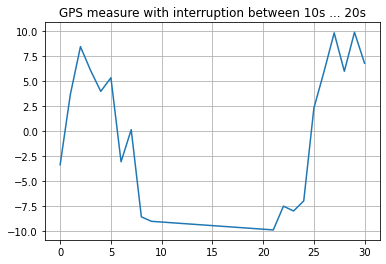

In [569]:
# Simulating an interruption of the GPS between 10s ... 20s
freq_list_Inter1 = [i for i in range(0,1000,100)]
freq_list_Inter2 = [i for i in range(2100,3000,100)]
freq_list_Inter = freq_list_Inter1 + freq_list_Inter2
freq_list_Inter.append(2999)

X_gps_Inter = [x[i] +0.8*samples[i] for i in freq_list_Inter ]
plt.plot(np.array(freq_list_Inter)/100,X_gps_Inter)
plt.grid()
plt.title("GPS measure with interruption between 10s ... 20s")


In [570]:
#implementation of kalman filter
P0_1 = np.array([[999999,0],[0,999999]])     # initial error state covariance matrix
x0_1 = np.array([[x0] ,[v0]])                  # Enter loop with initial state estimate

Hk =np.array([[1,0]])
Hk_T = np.transpose(Hk)

Rk = np.array([[5**2]])

Phi_K = np.array([[1,0.01],[0,1]])
Phi_K_T= np.transpose(Phi_K)

Ts = 0.01
Gamma = 2
Qk = (Gamma) * np.array([[(Ts**3)/3,(Ts**2)/2],[(Ts**2)/2,Ts]])
G_K = Ts * np.array([[0] ,[1]])


counter = 0
k=0
output = []
outputV2 =[]
for i in range(0,3000):
    PH = np.dot(P0_1,Hk_T) # P0_1*Hk_t
    K0 = np.dot(np.dot(P0_1,Hk_T),np.linalg.inv( np.dot(Hk,PH) + 15*Rk )) #kalman gain matrix
    P0_0 = np.dot(np.eye(2)-np.dot(K0,Hk),P0_1)  # updating state vector error covariance matrix
    P1_0 =  np.dot(Phi_K , np.dot(P0_0,Phi_K_T) ) + 1*Qk # Project ahead (extrapolation/ prediction step)
    P0_1 = P1_0
    if(counter in freq_list_Inter):
        x0_0  = x0_1 + np.dot(K0, X_gps_Inter[k] - np.dot(Hk,x0_1) ) #updating the last extrapolated state vector estimate
        x1_0 = np.dot(Phi_K,x0_0) + np.dot(G_K,X_acc[i]) # Project ahead (extrapolation/ prediction step)   Acc
        output.append(x1_0[0])
        outputV2.append(x1_0[1])
        k+=1
        x0_1 = x1_0
        counter+=1
    else:    
        x0_0 =  x0_1
        x1_0 = np.dot(Phi_K,x0_0) + np.dot(G_K,X_acc[i]) # Project ahead (extrapolation/ prediction step)   Acc
        output.append(x1_0[0])
        outputV2.append(x1_0[1])
        x0_1 = x1_0 
        counter+=1


	kalman filter, with an interruption of the GPS between 10s ... 20s




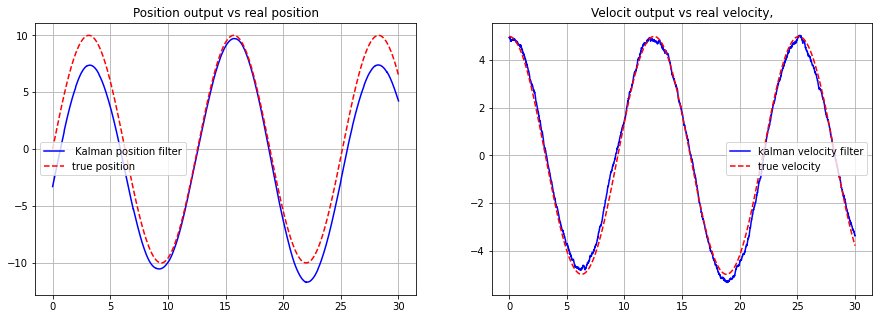

In [572]:
print("\n\tkalman filter, with an interruption of the GPS between 10s ... 20s\n\n")
plt.figure(2,figsize=(15,5))
plt.subplot(121)
plt.plot(t,output, label =" Kalman position filter", color ="blue") 
plt.plot(t,x, '--',label ="true position", color ="red") 
plt.title("Position output vs real position")
plt.legend()
plt.grid()
plt.subplot(122)
plt.plot(t,outputV2,label = "kalman velocity filter",color ="blue" )
plt.plot(t,V, '--',label ="true velocity", color ="red") 
plt.legend()
plt.title("Velocit output vs real velocity,")
plt.grid()
plt.show()

### Ici on peut voir qu'entre 0 et 10s le filtre de kalman a le meme comportement que celui qui était appliqué avant quand il n'y avais pas d'interruption dans le gps. Entre les secondes 10 et 20 on voit que le comportement du filtre de kalman n'est plus précis vu que ce dernier n'a plus de données provenant du gps (et donc la position), il se contente des données de l'accéléromètre (accélération), et par conséquent l'étape de mise à jour où les mesures du gps vont permettre d'obtenir une estimation des paramètres et de l'erreur à partir de la prédiction n'est pas faite pendant cet intevalle de temps.Enfin entre les secondes 20 et 30 on remarque que le filtre essaie de converger vers la vraie position puisqu'il prend en compte les données du gps qui font corriger son comportement et les errers de mesures précédentes